2024-04-15

Authors:
* Leandro SARAIVA MAIA
* Oscar BAUME

This notebook uses the **LEANDRONE_V1** dataset https://huggingface.co/datasets/Leandro4002/LEANDRONE_V1

# 1. Prepare the labels

In [1]:
import json
import random

# Load labels in a randomized order
with open('labels.json') as f:
    labels = json.load(f)
random_idx = list(range(len(labels)))
random.shuffle(random_idx)

L = []

scale = 200/320

# Correct labels so the point "from" is at the bottom of the image.
for i in random_idx:
    x1 = labels[i]["from"][0]
    y1 = labels[i]["from"][1]
    x2 = labels[i]["to"][0]
    y2 = labels[i]["to"][1]
    
    if x2-x1 == 0 :
        new_x = x2
    else :
        a = (y2 - y1) / (x2 - x1)  # Calculate slope    
        b = y1 - a * x1
        new_x = (320 - b)/a
    
    new_y = 320

    # Resize labels information to 200x200
    L.append({"from": [new_x*scale, new_y*scale], "to":[x2*scale,y2*scale]})

# 2. Prepare image dataset

In [2]:
import cv2
import torch

images = []

for i in random_idx:
    filename = f"render/{i}.png"
    img = cv2.imread(filename)

    # Grayscale image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize to 200x200
    img = cv2.resize(img, (200,200))

    ## Apply edge detection
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    img = cv2.magnitude(sobel_x, sobel_y)

    # 0-255 --> 0-1
    img = img / 255.0
    images.append(img)

tensor_images = torch.tensor(images, dtype=torch.float32)
tensor_images = tensor_images.unsqueeze(1)

/tmp/ipykernel_272360/3444956057.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  tensor_images = torch.tensor(images, dtype=torch.float32)


# 3. Display some random samples

/tmp/ipykernel_272360/383881646.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(L[random_index]["from"][0], L[random_index]["from"][1], 'ro', c="brown")
/tmp/ipykernel_272360/383881646.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(L[random_index]["to"][0], L[random_index]["to"][1], 'ro', c="green")


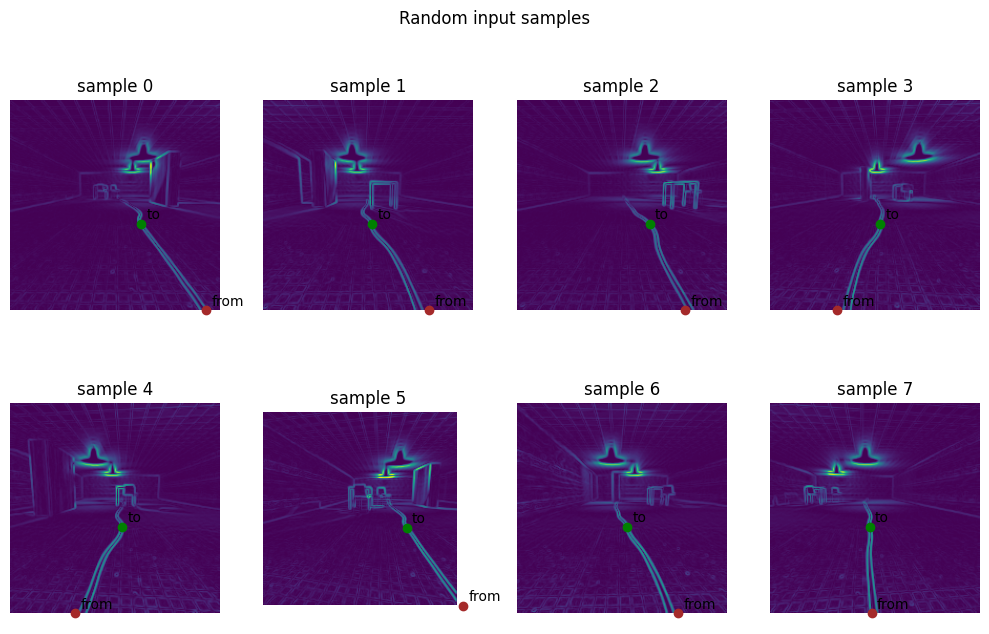

In [3]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 4
i = 0
plt.suptitle("Random input samples")
for random_index in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(images[random_index])
    plt.axis('off')
    plt.title('sample %d' % i)
    plt.plot(L[random_index]["from"][0], L[random_index]["from"][1], 'ro', c="brown")
    plt.plot(L[random_index]["to"][0], L[random_index]["to"][1], 'ro', c="green")
    plt.annotate("from", (L[random_index]["from"][0] + 5, L[random_index]["from"][1] - 5))
    plt.annotate("to", (L[random_index]["to"][0] + 5, L[random_index]["to"][1] - 5))
    i += 1
plt.tight_layout()

# 4. Create model layer topography

In [4]:
import torch
import torch.nn as nn
from point_finder import PointFinder

# Hyperparameters
learning_rate = 0.0001
num_epochs = 300

model = PointFinder()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(model)

PointFinder(
  (conv): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=160000, out_features=4, bias=True)
)


# 5. Separate images into train and evaluation set

In [5]:
len_images = len(images)
images_idx = range(len_images)
middle_idx = int(len_images * 0.8)
train_idx = images_idx[0:middle_idx]
eval_idx = images_idx[middle_idx:]
tensor_train = tensor_images[0:middle_idx]
tensor_eval = tensor_images[middle_idx:]
print("     Train samples: %d" % len(train_idx))
print("Evaluation samples: %d" % len(eval_idx))
print("     Total samples: %d" % len_images)

     Train samples: 400
Evaluation samples: 100
     Total samples: 500


# 6. Train the model

<font style="color:red">CAREFUL! This node can take up to 5-10 minutes</font>

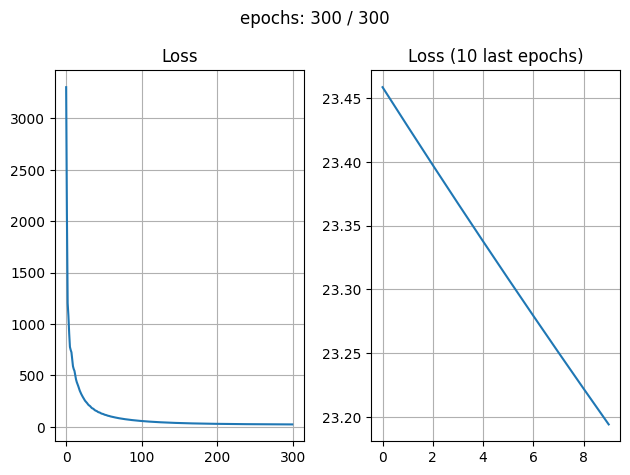

In [6]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

# Compute target values for training dataset
T_list = []
for j in range(middle_idx):
    target = [L[j]["from"][0], L[j]["from"][1], L[j]["to"][0], L[j]["to"][1]]
    target = torch.tensor(target)
    T_list.append(target)
T = torch.stack(T_list, dim=0)

losses = []
for i in range(num_epochs):
    # Predict
    Q = model(tensor_train)

    # Adjust weights
    optimizer.zero_grad()
    loss = criterion(T, Q)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    # Plot loss on a graph
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].set_title("Loss")
    ax[0].plot(losses)
    ax[0].grid()
    ax[1].set_title("Loss (10 last epochs)")
    ax[1].plot(losses[-10:])
    ax[1].grid()
    fig.suptitle('epochs: %d / %d' % (i + 1, num_epochs))
    plt.tight_layout()
    plt.show()
    clear_output(wait=True)


# 7. Evalutate the model

In [7]:
import math

def dist_point(ground_truth, predicted_values):
    true_x1 = ground_truth[0].item()
    true_y1 = ground_truth[1].item()
    true_x2 = ground_truth[2].item()
    true_y2 = ground_truth[3].item()

    predicted_x1 = predicted_values[0].item()
    predicted_y1 = predicted_values[1].item()
    predicted_x2 = predicted_values[2].item()
    predicted_y2 = predicted_values[3].item()

    delta_x1 = abs(predicted_x1 - true_x1)
    delta_x2 = abs(predicted_x2 - true_x2)
    delta_y1 = abs(predicted_y1 - true_y1)
    delta_y2 = abs(predicted_y2 - true_y2)
    dist_p1 = math.sqrt(delta_x1 * delta_x1 + delta_y1 * delta_y1)
    dist_p2 = math.sqrt(delta_x2 * delta_x2 + delta_y2 * delta_y2)

    return (dist_p1, dist_p2)

# Compute target values for evaluation dataset
T_list = []
for j in range(middle_idx, middle_idx + tensor_eval.shape[0]):
    target = [L[j]["from"][0], L[j]["from"][1], L[j]["to"][0], L[j]["to"][1]]
    target = torch.tensor(target)
    T_list.append(target)
T_eval = torch.stack(T_list, dim=0)

# Predict
Q_eval = model(tensor_eval)

# Adjust weights
loss = criterion(T_eval, Q_eval).item()

# Compute average pixel distance error when predicting points
average_dist_from = 0
average_dist_to = 0
for i in range(Q_eval.shape[0]):
    from_pt, to_pt = dist_point(Q_eval[0], T_eval[0])
    average_dist_from += from_pt
    average_dist_to += to_pt
average_dist_from /= Q_eval.shape[0]
average_dist_to /= Q_eval.shape[0]

print("Average pixel distance error with \"from\" point: %f" % average_dist_from)
print("Average pixel distance error with \"to\" point: %f" % average_dist_to)
print("Loss: %f" % loss)


Average pixel distance error with "from" point: 4.234004
Average pixel distance error with "to" point: 6.674154
Loss: 181.495941


# 8. Display some evaluations samples

/tmp/ipykernel_272360/4172175991.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(true_pts[0], true_pts[1], "ro", c="brown")
/tmp/ipykernel_272360/4172175991.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(true_pts[2], true_pts[3], "ro", c="green")
/tmp/ipykernel_272360/4172175991.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(pred_pts[0], pred_pts[1],'ro', c="orangered", marker="x")
/tmp/ipykernel_272360/4172175991.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(pred_pts[0], pred_pts

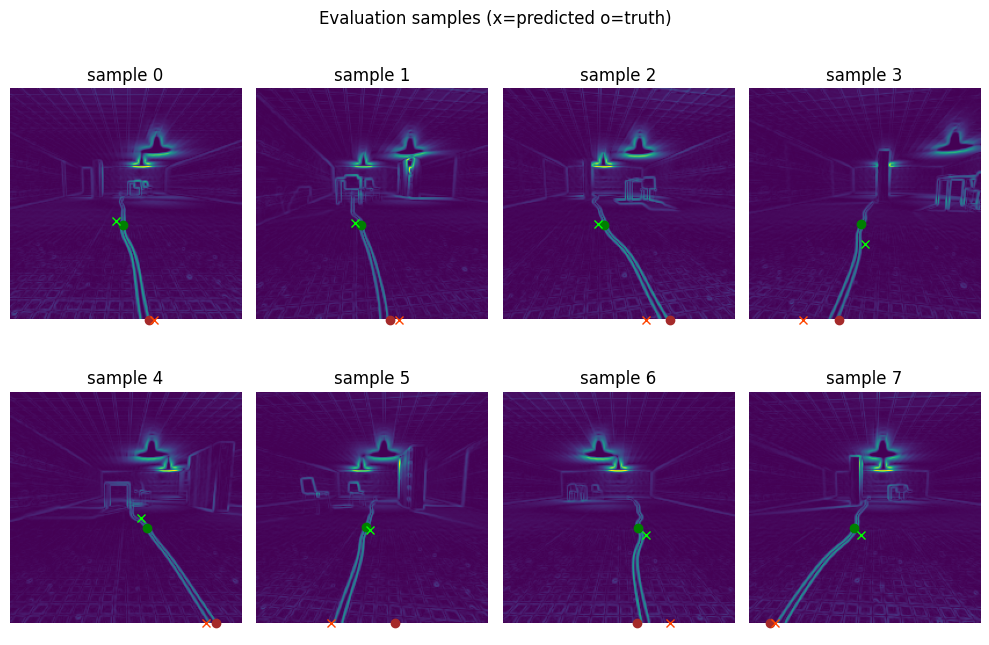

In [8]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 4
plt.suptitle("Evaluation samples (x=predicted o=truth)")
i = 0
for index in range(middle_idx, middle_idx + rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(images[index])
    plt.axis('off')
    plt.title('sample %d' % i)
    
    # Plot true points
    true_pts = T_eval[i].detach().numpy()
    plt.plot(true_pts[0], true_pts[1], "ro", c="brown")
    plt.plot(true_pts[2], true_pts[3], "ro", c="green")

    # Plot prediction points
    pred = model(tensor_images[index:index+1])
    pred_pts = pred.detach().numpy()[0]
    plt.plot(pred_pts[0], pred_pts[1],'ro', c="orangered", marker="x")
    plt.plot(pred_pts[2], pred_pts[3],'ro', c="lime", marker="x")

    i += 1

plt.tight_layout()

# 9. Save the model to a file

In [9]:
torch.save(model.state_dict(), "followLineModel.pth")